In [1]:
# Loading CHARMM system with JAX-MD OPLSAA
from jax_md.mm_forcefields import oplsaa
import jax.numpy as jnp
from jax import jit

positions, topology, parameters = oplsaa.load_charmm_system(
    'notebooks/data/torsion-data/scan_1.pdb',
    'notebooks/data/torsion-data/scan_1.prm',
    'notebooks/data/torsion-data/scan_1.rtf'
)

for k, v in topology._asdict().items():
    print(f"{k}: {f'shape={v.shape}' if hasattr(v, 'shape') else v}")

n_atoms: 22
bonds: shape=(23, 2)
angles: shape=(36, 3)
torsions: shape=(52, 4)
impropers: shape=(12, 4)
exclusion_mask: shape=(22, 22)
pair_14_mask: shape=(22, 22)
molecule_id: shape=(22,)


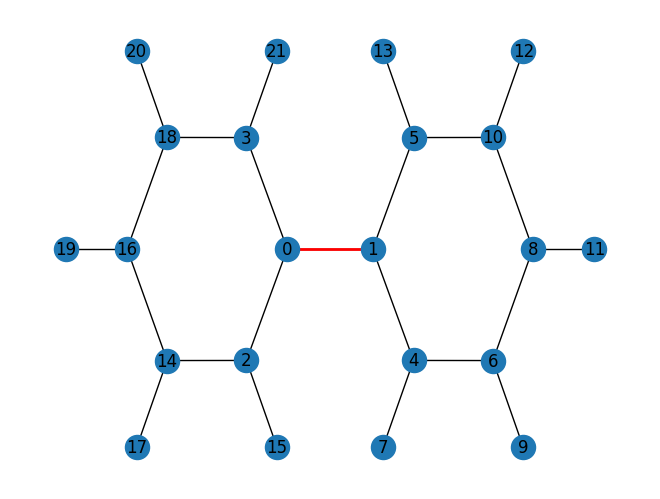

In [3]:
# Draw the parsed molecule system with networkx
import networkx as nx
pos_2d = positions[:, :2]
bonds = topology.bonds

G = nx.Graph()
G.add_nodes_from(range(topology.n_atoms))
G.add_edges_from(bonds.tolist())

# we will study the molecules energy while rotating around the 0-1 bond
nx.draw(G, pos=pos_2d, with_labels=True)
nx.draw_networkx_edges(G, pos_2d, edgelist=[(0, 1)], edge_color='red', width=2)

In [4]:
# Setup energy function with PME electrostatics
from jax_md.mm_forcefields.nonbonded.electrostatics import PMECoulomb
from jax_md.mm_forcefields.base import NonbondedOptions

# Estimate box size (large enough to avoid self-interaction)
coords_range = jnp.max(positions, axis=0) - jnp.min(positions, axis=0)
box_size = coords_range + 20.0  # Add 20 Å buffer
box = jnp.array([box_size[0], box_size[1], box_size[2]])

# Setup nonbonded options
nb_options = NonbondedOptions(
    r_cut=12.0,
    dr_threshold=0.5,
    scale_14_lj=0.5,
    scale_14_coul=0.5,
    use_soft_lj=False,
    use_shift_lj=False
)

# Setup PME coulomb
coulomb = PMECoulomb(grid_size=32, alpha=0.3, r_cut=12.0)

# Create energy function
energy_fn, neighbor_fn, displacement_fn = oplsaa.energy(
    topology, parameters, box, coulomb, nb_options
)

# JIT compile the energy function
energy_fn_jit = jit(energy_fn) # (Array, NeighborList) -> dict[str, Array]

In [5]:
# Test initial energy
nlist = neighbor_fn.allocate(positions)

E_init = energy_fn_jit(positions, nlist)

for k, v in E_init.items():
    print(f"{k}: {v}")

angle: 0.24456177651882172
bond: 1.4150340557098389
coulomb: -1.1449871063232422
improper: 0.0109158456325531
lj: -0.5141606330871582
torsion: 0.0
total: 0.011363983154296875


In [6]:
from collections import deque


def find_bond_sides(
    bonds: jnp.ndarray, bond_idx_to_break: tuple[int, int]
) -> tuple[set[int], set[int]]:
    n_atoms = int(bonds.max()) + 1
    bond_i, bond_j = bond_idx_to_break

    adjacency = [set() for _ in range(n_atoms)]
    for atom1, atom2 in bonds:
        atom1, atom2 = atom1.item(), atom2.item()
        if (atom1 == bond_i and atom2 == bond_j) or (
            atom1 == bond_j and atom2 == bond_i
        ):
            continue
        adjacency[atom1].add(atom2)
        adjacency[atom2].add(atom1)

    side1 = set()
    queue = deque([bond_i])
    visited = set([bond_i])

    while queue:
        atom = queue.popleft()
        side1.add(atom)
        for neighbor in adjacency[atom]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)

    side2 = set()
    queue = deque([bond_j])
    visited = set([bond_j])

    while queue:
        atom = queue.popleft()
        side2.add(atom)
        for neighbor in adjacency[atom]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)

    return side1, side2


def set_dihedral_angle(pos, bonds, bond_atoms, target_angle_deg, verbose=False):
    """
    Set a dihedral angle by rotating atoms around a bond.
    Uses graph connectivity to correctly identify which atoms to rotate.

    Args:
        pos: Atomic positions (n_atoms, 3)
        bonds: Array of bond pairs (n_bonds, 2)
        bond_atoms: [i, j] indices of the central bond
        target_angle_deg: Target dihedral angle in degrees
        verbose: Print debug info

    Returns:
        New positions with the dihedral set to target angle
    """
    pos = jnp.array(pos)
    i, j = bond_atoms

    _, side2 = find_bond_sides(bonds, bond_atoms)
    axis_vec = pos[j] - pos[i]
    axis_vec = axis_vec / jnp.linalg.norm(axis_vec)
    center = pos[i]
    angle_rad = jnp.radians(target_angle_deg)

    def rotate_point(p, axis, angle, center):
        """Rotate point p around axis by angle, with rotation center."""
        p_shifted = p - center
        cos_a = jnp.cos(angle)
        sin_a = jnp.sin(angle)

        p_rot = (
            p_shifted * cos_a
            + jnp.cross(axis, p_shifted) * sin_a
            + axis * jnp.dot(axis, p_shifted) * (1 - cos_a)
        )

        return p_rot + center

    new_pos = pos.copy()
    for atom_idx in side2:
        if atom_idx != i:
            new_pos = new_pos.at[atom_idx].set(
                rotate_point(pos[atom_idx], axis_vec, angle_rad, center)
            )

    return new_pos


bonds_array = jnp.array(topology.bonds)  # Get bonds from topology
sidea, sideb = find_bond_sides(bonds_array, (0, 1))


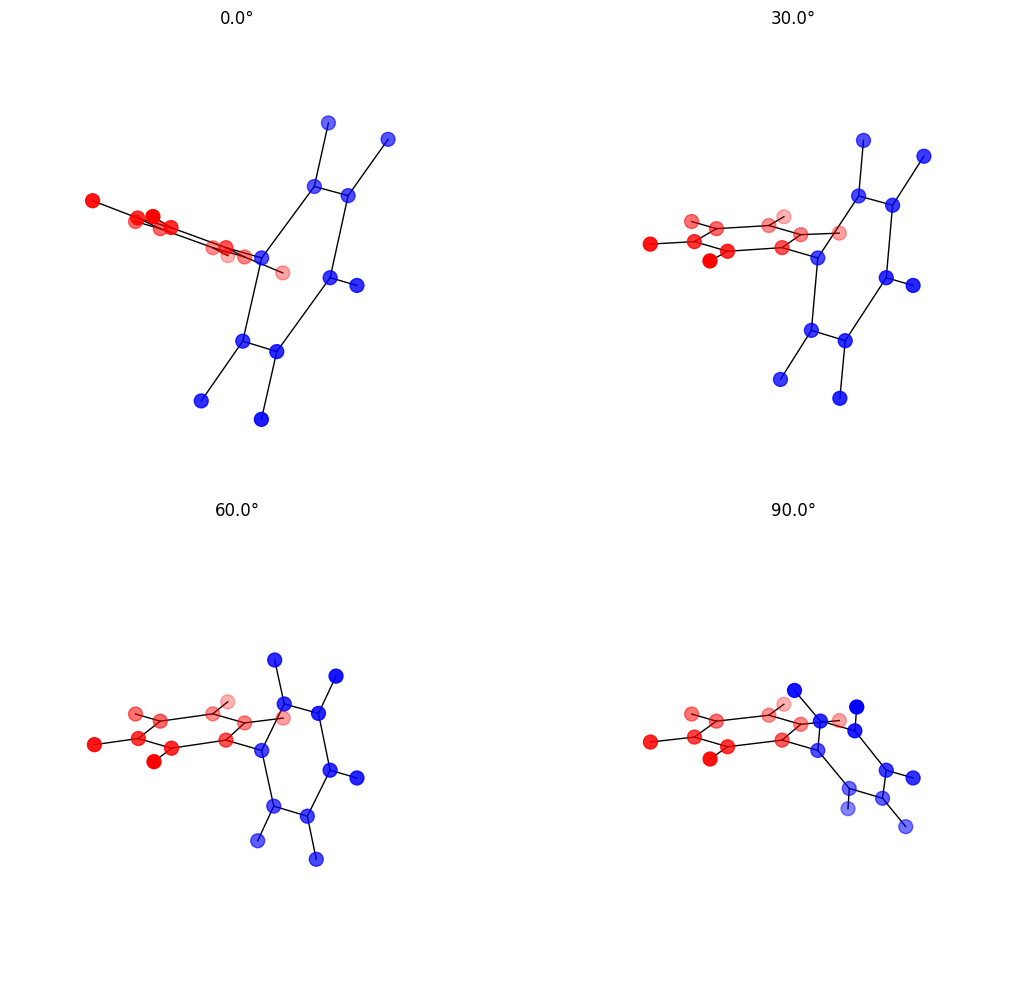

In [8]:
import matplotlib.pyplot as plt

# Visualize the molecule at various dihedral angles
fig = plt.figure(figsize=(12, 10))
angles_to_plot = jnp.linspace(0, 90, 4)
for idx, angle in enumerate(angles_to_plot, 1):
    pos = set_dihedral_angle(positions, bonds_array, (0, 1), angle)
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    
    # Color atoms by which side of the bond they're on
    colors = ['red' if i in sidea else 'blue' for i in range(len(pos))]
    ax.scatter(*pos.T, c=colors, s=100)
    
    # Draw bonds
    for bond in bonds_array:
        i, j = bond
        ax.plot([pos[i, 0], pos[j, 0]], 
                [pos[i, 1], pos[j, 1]], 
                [pos[i, 2], pos[j, 2]], 'k-', linewidth=1)
    
    # ax.view_init(elev=20, azim=20)
    ax.set_title(f'{angle}°')
    ax.set_axis_off()
plt.tight_layout()

Performing torsion scan...
    0°: E =     0.0114 kcal/mol
   30°: E =    -0.3059 kcal/mol
   60°: E =    -0.3069 kcal/mol
   90°: E =     0.0792 kcal/mol
  120°: E =     0.8877 kcal/mol
  150°: E =     0.7918 kcal/mol
  180°: E =     0.0114 kcal/mol

Scan complete!
Min energy: -0.4004 kcal/mol at 45°
Max relative energy: 1.0172 kcal/mol at 130°


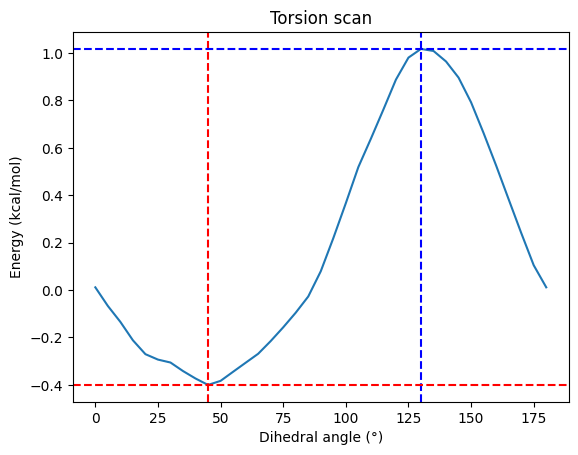

In [11]:
# Perform torsion scan from 0 to 360 degrees
print("Performing torsion scan...")

angles_deg = jnp.arange(0, 181, 5)
energies = []
nlist = neighbor_fn.allocate(positions)

for angle_deg in angles_deg:
    # Set the dihedral angle
    pos_rotated = set_dihedral_angle(positions, bonds_array, [0, 1], angle_deg)
    pos_rotated_jax = jnp.array(pos_rotated)
    
    # Update neighbor list
    nlist = neighbor_fn.update(pos_rotated_jax, nlist)
    
    # Compute energy
    E = energy_fn_jit(pos_rotated_jax, nlist)
    energies.append(float(E['total']))
    
    if angle_deg % 30 == 0:
        print(f"  {angle_deg:3d}°: E = {E['total']:>10.4f} kcal/mol")

energies = jnp.array(energies)

e_argmin = energies.argmin()
e_min = energies[e_argmin]
angle_min = angles_deg[e_argmin]

e_argmax = energies.argmax()
e_max = energies[e_argmax]
angle_max = angles_deg[e_argmax]


print(f"\nScan complete!")
print(f"Min energy: {e_min:.4f} kcal/mol at {angle_min:.0f}°")
print(f"Max relative energy: {e_max:.4f} kcal/mol at {angle_max:.0f}°")
plt.plot(angles_deg, energies)
plt.xlabel("Dihedral angle (°)")
plt.ylabel("Energy (kcal/mol)")
plt.title("Torsion scan")
plt.axvline(angle_min.item(), color='red', linestyle='--')
plt.axvline(angle_max.item(), color='blue', linestyle='--')
plt.axhline(e_min.item(), color='red', linestyle='--')
plt.axhline(e_max.item(), color='blue', linestyle='--')
plt.show()


In [44]:
# compute forces

def e_total_func(pos, nlist):
    E = energy_fn_jit(pos, nlist)
    return E['total']

from jax import grad
force_fn = jit(grad(e_total_func))

forces = force_fn(positions, nlist)

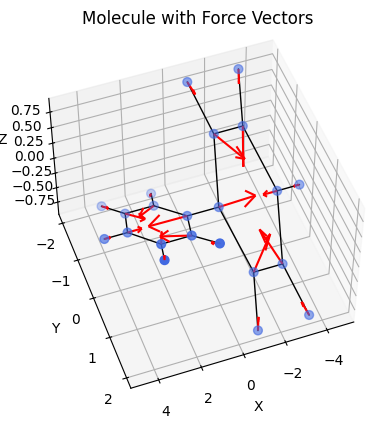

In [48]:
import numpy as np
def plot_molecule_with_forces(positions, forces, bonds, force_scale=1.0):
    """
    positions: (N, 3)
    forces:    (N, 3)
    bonds:     (M, 2) each row stores indices [i, j]
    force_scale: multiply forces for visualization
    """

    positions = np.asarray(positions)
    forces = np.asarray(forces) * force_scale
    bonds = np.asarray(bonds)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot atoms
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=40, c="royalblue")

    # Plot bonds
    for i, j in bonds:
        p1 = positions[i]
        p2 = positions[j]
        midpoint = (p1 + p2) / 2
        vec = (p2 - p1) * 1 / 2
        ax.plot(
            [midpoint[0] - vec[0], midpoint[0] + vec[0]],
            [midpoint[1] - vec[1], midpoint[1] + vec[1]],
            [midpoint[2] - vec[2], midpoint[2] + vec[2]],
            color="black",
            linewidth=1,
        )

    # Plot forces as arrows
    for p, f in zip(positions, forces):
        ax.quiver(
            p[0], p[1], p[2],
            f[0], f[1], f[2],
            length=1,
            normalize=False,
            color="red"
        )

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Molecule with Force Vectors")
    ax.view_init(elev=50, azim=70)

    plt.show()


plot_molecule_with_forces(positions, forces, bonds, force_scale=.08)
